# 1. Introduction: The Crime Analysis Task

### 1.1 Background of the task

Violent crimes are among the top concern of government, and policy makers and the pledge to reduce or ‘fight crime’ is among the top agenda of politicians. [1] remarked that the drive for the authorities to publish crime data publicly has increased in the last decade, prompting the UK to publish crime statistics in a public website called police.uk. This report will review existing literature to understand the relationship between violent crimes, firearm incidents and drug offences.

The types of criminal activities considered as violent crimes differs in different countries. In the UK, murder and manslaughter, assault, knife and gun crimes, attack using corrosive substances, and robberies are considered violent crimes [2]. However, the US adds forcible rape and aggravated assault in addition to crimes considered in the UK (except acid attacks) as violent crimes [3]. 

In 2018, Birmingham was cited as the ‘gun and gang capital’ of the UK after reportedly witnessing more than twice the national average for firearm incidents [4] quoted in [5]. Homicide, which is a common result of violent crimes, is a leading cause of death worldwide and firearms are the leading means making up about 48% to 74% of homicides [6]. 

Similarly, substance/drug abuse and alcohol misuse at the individual, family or neighborhood levels  have been associated with increased incidence of adolescent firearm homicide [7]. Furthermore, stricter gun control especially handguns have been found to correlate with less suicide deaths ([8] quoted in [9]) while [10] concluded that a 35% increase in gun theft facilitated a 29% increase in firearm violent crime in the US in recent years. 



### 1.2 Aims and objectives of this report

This report aims to analyze the UK crime data focusing on violent crime, firearm incidents and drug offences to determine if violent crime is increasing, and if there is a correlation between firearm incidents and drug offences. This report will also analyze the proportion of firearm incident per head in the UK to understand if Birmingham’s has the highest. Due to the size of the full dataset, these analyses were tested on a subset of the dataset first before repeating same steps on the whole dataset. 

### 1.3 Technical Approach

To achieve the aims of this report, the following approach will be followed:

a.	Import all relevant libraries to support both big data and cloud computing aspects of the assessment.

b.	Import all datasets needed namely, all_crimes dataset, 1% sample of all_crimes dataset, and the postcode dataset. The all_crimes dataset alone is sufficient in analyzing whether violent crimes are increasing and whether firearm incidents are closely associated with drugs offences. The sample dataset was first utilized to test the codes before using the full dataset.

c.	Extract the column(s) relating to the relevant crime in claim 1 (“Violent crime”). This report is only interested in the ‘Violent crime’ and ‘Violence and sexual offences’ crime types. To view a time series of violent crime occurrence, the monthly count of violent crimes is visualized using sm.tsa.seasonal_decompose() function in pandas. The monthly counts and annual average counts of Violent crimes are also viewed as a line chart. 

d.	To investigate if there are more firearm incidents per head in Birmingham than anywhere else in the UK, the chosen approach is to analyze this annually instead of monthly. Firstly, the rows/columns relating to firearm incidents are extracted from all_crimes dataset and this is joined with the postcode dataset. Then the annual count of all firearm incidents is gotten for all cities (saved as Districts) in the UK, and the top 5 districts annually are ranked. The ranking of Birmingham over years was extracted.

e.	To investigate if firearm related crimes are correlated with drug offences, the rows/columns  relating to firearm incidents are extracted from the crime dataset. Afterwards, the monthly counts of both crimes are gotten and are visualized using a scatterplot and the correlation coefficients are obtained. 


# 2. Component Selection and Data Pipeline Implementation code

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import itertools

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from pyspark import SparkFiles
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
import pyspark.sql.functions as f 
from pyspark.sql.functions import count, avg, sum, col, to_date, lit, when, coalesce, year, row_number
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, Summarizer

%matplotlib inline
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller  

In [2]:
spark = SparkSession.builder.appName("Python Spark app").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark app>

In [3]:
# upload a subset of the deprivation dataset
#  this df was used in the developement
df = spark.read.csv('Sample_1pc_Data.csv', header = 'true', inferSchema= True)

In [3]:
# upload all_crimes dataset
url = "https://22kf7032unn.blob.core.windows.net/unn/all_crimes21_hdr.txt.gz"
spark.sparkContext.addFile(url)
df = spark.read.csv("file://" + SparkFiles.get("all_crimes21_hdr.txt.gz"), header=True, inferSchema= True)

In [4]:
df.show(5, truncate=False)

+--------+-------+------------------------------+------------------------------+---------+---------+--------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|Crime ID|Month  |Reported by                   |Falls within                  |Longitude|Latitude |Location                  |LSOA code|LSOA name                        |Crime type           |Last outcome category|Context|
+--------+-------+------------------------------+------------------------------+---------+---------+--------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|null    |2010-12|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-0.8056  |51.819143|On or near Norfolk Terrace|E01017662|Aylesbury Vale 015C              |Other crime          |null                 |null   |
|null    |2010-12|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-2.494366|51.418169|On o

In [5]:
df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [6]:
# check how many observations (i.e. rows) the dataset has
df.count()

65078250

In [7]:
# display missing values in the dataset
df_nulls = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.show()

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|24242335|    0|          0|           0|   957447|  957447|       0|  2528265|  2528265|         0|             26418132|64955845|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



In [8]:
# since the missing data in the LSOA code and LSOA name is just about 4% of the entire dataset, those rows would be 
# discarded. The Crime ID column is not material so that would be removed entirely.
df = df.na.drop(subset = ['LSOA code', 'LSOA name'])
df.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

# Claim 1: Violent Crimes are increasing

## Data Extraction and Filtering

This section explained the process of extracting the relevant rows/columns needed to access the first claim. 

From the dataset violent crimes were previously recorded as 'Violent crimes' up until April 2013 when the nomenclature changed to  'Violence and sexual offences'. Hence, both crime types are extracted alongside the 'Month' column.

In [9]:
# display unique crimes in Crime type column
# use truncate = False to show full output
df.select("Crime type").distinct().show(truncate=False)

+----------------------------+
|Crime type                  |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
|Anti-social behaviour       |
+----------------------------+



In [10]:
# check if there are 'Violence and sexual offences' crime type recorded in 2012
df.select('Month').where((df['Month'] == '2012-01') & (df['Crime type'] == 'Violence and sexual offences')).show(5)

+-----+
|Month|
+-----+
+-----+



In [11]:
# check if there are 'Violent crime' crime type recorded in 2015
df.select('Month').where((df['Month'] == '2015-01') & (df['Crime type'] == 'Violent crime')).show(5)

+-----+
|Month|
+-----+
+-----+



In [12]:
# extract the Date column and rows relating to 'Violent crime' Crime type only
violent_crime = df.select(to_date(col("Month"),"yyyy-MM").alias("Date"),'Crime type')\
                    .where((df['Crime type'] == 'Violent crime')|(df['Crime type'] == 'Violence and sexual offences'))
violent_crime.show(5)

+----------+-------------+
|      Date|   Crime type|
+----------+-------------+
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 5 rows



## Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures

### Objective:
To access the claim that Violent crimes are increasing, the occurrence of this crime is counted monthly. Monthly basis was chosen as this is the most granular timeframe recorded in the dataset. Afterwards, a column for 'Year' is added to the dataset and an aggregate measure (average count) is calculated. Average count was used since some years such as 2010 and 2021 do not have records for the entire year.

In [13]:
# count the monthly occurence of crime and sort the Date column in descending order
count_by_month = violent_crime.groupBy('Date').count().select('Date', f.col('count').alias('count')).sort('Date')

# To use the Time series function in pandas, convert dataset to pandas
pcount_by_month = count_by_month.toPandas()
pcount_by_month.head()

,Date,count
0,2010-12-01,57517
1,2011-01-01,59776
2,2011-02-01,56624
3,2011-03-01,62264
4,2011-04-01,64060


In [14]:
pcount_by_month.tail()

,Date,count
121,2021-01-01,136351
122,2021-02-01,130181
123,2021-03-01,160269
124,2021-04-01,147015
125,2021-05-01,163297


In [15]:
# looking at the average count of crime annually
# count the monthly occurence of crime and sort the Date column in descending order
count_by_year = violent_crime.groupBy('Date').count().select('Date', f.col('count').alias('count')).sort('Date')

# add 'Year' column
count_by_year = count_by_year.withColumn('Year', year(col('Date')))

# group by year and get average count
count_by_year = count_by_year.groupBy('Year').agg({'count': 'mean'})

count_by_year.show(5)

+----+------------------+
|Year|        avg(count)|
+----+------------------+
|2018|140810.91666666666|
|2015| 82571.91666666667|
|2013|          53705.25|
|2014| 65687.41666666667|
|2019|148800.91666666666|
+----+------------------+
only showing top 5 rows



In [16]:
# looking at the yearly count
# convert dataset to pandas
pcount_by_year = count_by_year.toPandas()
pcount_by_year

,Year,avg(count)
0,2018,140810.916667
1,2015,82571.916667
2,2013,53705.250000
3,2014,65687.416667
4,2019,148800.916667
5,2020,148689.083333
6,2012,52998.083333
7,2016,97703.750000
8,2010,57517.000000
9,2011,59644.166667


### Observations:
From pcount_by_month head and tail, it can be seen that the monthly count of violent crimes was much lower in 2010 and 2011 when compared to 2021. Also, from pcount_by_year, there is a steady decrease in the average annual count of violent crimes between 2011 and 2012 while it remained steady in 2013. However, there is a considerable increase in the average year-on-year count from 2014 to 2019. 

## Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models

### Objective
The monthly counts is visualized using a line chart and time series charts. The line chart will show the monthly progression of the counts while the time series charts will show the general trend of the monthly counts, and information about seasonality and residuals. The dataset is also tested for stationarity used the ADF_test function.

The annual average counts are also visualized using a barchart as this will clearly show the trend of violent crimes annually.

In [17]:
# change the index created automatically to an index based on datetimes
pcount_by_month.Date = pcount_by_month.Date.astype('datetime64[ns]')
pcount_by_month = pcount_by_month.set_index(pd.to_datetime(pcount_by_month.Date))

<Figure size 90000x432 with 0 Axes>

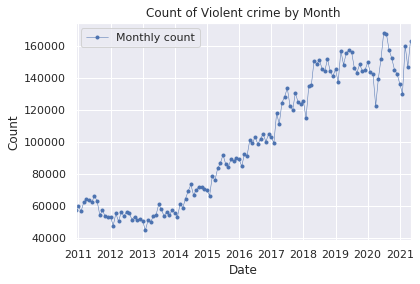

In [18]:
# plot a line chart of monthly count of violent crime
plt.figure(figsize=(1250, 6))
pcount_by_month.plot(x='Date', y='count', marker='.', linestyle='-', linewidth=0.5,subplots=False, 
                     label='Monthly count', title='Count of Violent crime by Month')
plt.ylabel('Count')
plt.show()


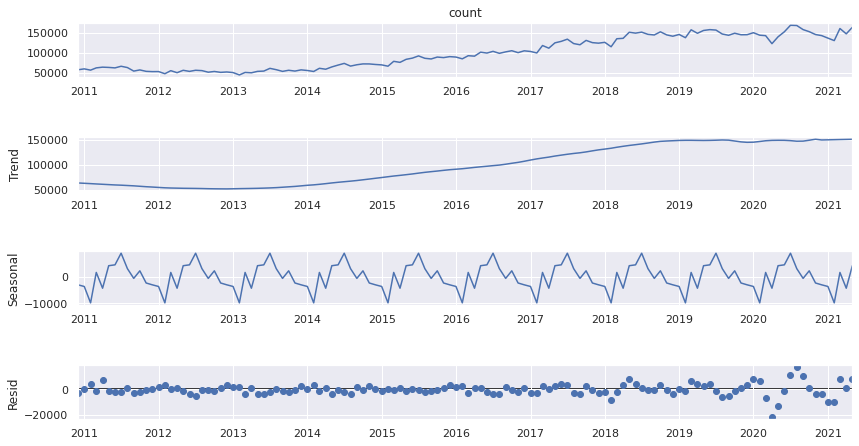

In [19]:
# time series decomposition 
# this allows the decomposition of the data into seasonal, trend and residual components
# this block decomposes the Count column
decomposition = sm.tsa.seasonal_decompose(pcount_by_month['count'], model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

In [20]:
# test for stationarity
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '',\
                                                                                100-int(k[:-1])))

In [21]:
ADF_test(pcount_by_month['count'], 'Monthly count of violent crime') 
# this shows the monthly count of violent crime is not stationary

 > Is the Monthly count of violent crime stationary ?
Test statistic = -0.293
P-value = 0.927
Critical values :
	1%: -3.4901313156261384 - The data is not stationary with 99% confidence
	5%: -2.8877122815688776 - The data is not stationary with 95% confidence
	10%: -2.5807296460459184 - The data is not stationary with 90% confidence


[Text(0.5, 1.0, 'Average count of violent crimes by year')]

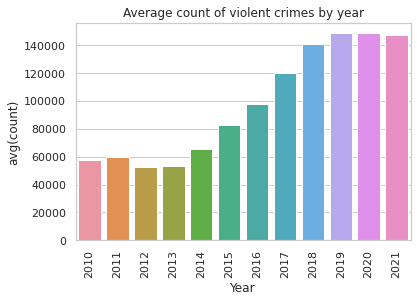

In [22]:
# plot a line chart of monthly count of violent crime
# visualize this using a boxplot in seaborn. This seems more appropriate.
sns.set(style='whitegrid')
plt = sns.barplot(y='avg(count)', x='Year', data=pcount_by_year)
plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
plt.set(title='Average count of violent crimes by year')

### Observations:

These plots show more clearly the earlier observations about the monthly and annual average counts of violent crimes.

From the line chart, the lowest count of violent crimes was recorded in 2013. This drop in violent crimes resonates with [11]’s remarks that violent crimes fell dramatically between 1995 and 2013/2014. They authors concluded that this decline was driven by a fall in acquaintance violence on young individuals.

However, 2014 to 2019 witnessed a dramatic year-on-year increase in violent crimes also resonating with [12]’s research which confirmed the increasing trend in violent crimes in the UK in the years leading up to 2018. The authors found that that violent crimes were higher in areas with increseased deprivation and alcohol availability.

There was a significant drop in early 2020 mainly due to the COVID-19 pandemic and subsequent lockdowns which reduced mobility. This was followed by a big spike in late 2020/early 2021 which recorded the highest monthly count of violent crime throughout the review period. [13] referred to this as ‘post-lockdown bounce-back’. 

Overall, the claim in 2018 that Violent crimes are increasing is True since there was a significant increase both the monthly and annual average counts of violent crimes in the UK leading up to 2018. The time series chart also show an increasing trend and this was shown to be non-stationary. However, since 2019, average counts of violent crimes have declined marginally year-on-year.

# Claim 2: Firearm incidents per head in Birmingham is higher than anywhere else in the UK 

## Data Extraction and Filtering

Step 1: Determine what constitutes a 'Firearm incident' and extract the rows/columns relating to this crime alongside the 'Month' and 'LSOA name' columns.
Assumption: Crime type of “Possession of weapons” whose outcome is “offender sent to prison” is a firearm incident. 

Step 2: Determine the proxy to be used for towns/cities such as Birmingham from the given datasets. 
The postcode dataset was chosen as it contains information about 'Districts' which are town/cities in the UK alongside the Population of each postcode in each District. This dataset is then joined with all_crimes dataset on LSOA name which both datasets have.

Step 3: Extract the columns relating to crime type, date, district, and population.

In [23]:
# extract the Date column and rows relating to 'Drugs' and 'Possession of weapons' Crime type only. For 'Possession 
# of weapons' Crime type, select rows where the Last outcome category is 'Offender sent to prison'
drugs_guns = df.select(to_date(col("Month"),"yyyy-MM").alias("Date"),'LSOA name','Crime type', 'Last outcome category')\
        .where((df['Crime type'] == 'Possession of weapons') & (df ['Last outcome category'] == 'Offender sent to prison'))

In [24]:
# take a look at the columns that have location data 'LSOA name'
drugs_guns.select('LSOA name').distinct().show(truncate=False)

+-----------------------+
|LSOA name              |
+-----------------------+
|Sheffield 074C         |
|Bradford 039G          |
|Liverpool 044D         |
|Amber Valley 010C      |
|Blackpool 010D         |
|Oxford 008A            |
|Sheffield 074D         |
|Hounslow 014C          |
|Hackney 024E           |
|Leeds 041B             |
|Isle of Anglesey 001A  |
|Rhondda Cynon Taf 011C |
|North Lincolnshire 008B|
|Redditch 004B          |
|Leeds 085B             |
|Wyre Forest 010A       |
|Cornwall 066C          |
|Dudley 039B            |
|Newham 033C            |
|Telford and Wrekin 003C|
+-----------------------+
only showing top 20 rows



In [25]:
# load the postcode data
url = "https://22kf7032unn.blob.core.windows.net/unn/postcodes.gz"
spark.sparkContext.addFile(url)
postcodes = spark.read.csv("file://" + SparkFiles.get("postcodes.gz"), inferSchema= True)

In [26]:
postcodes.show(3)

+-------+---+---------+---------+------+------+--------+----+-------------+-------------+----------+---------+--------+---------+--------------+----------+----------+----+----+----+----+----+----+--------------------+--------------------+----+----+
|    _c0|_c1|      _c2|      _c3|   _c4|   _c5|     _c6| _c7|          _c8|          _c9|      _c10|     _c11|    _c12|     _c13|          _c14|      _c15|      _c16|_c17|_c18|_c19|_c20|_c21|_c22|                _c23|                _c24|_c25|_c26|
+-------+---+---------+---------+------+------+--------+----+-------------+-------------+----------+---------+--------+---------+--------------+----------+----------+----+----+----+----+----+----+--------------------+--------------------+----+----+
|AB1 0AA| No|57.101478|-2.242852|385386|801193|NJ853011|null|Aberdeen City|Lower Deeside| S12000033|S13002484|Scotland|S99999999|Aberdeen South|1980-01-01|1996-06-01|null|null|null|null|null|null|Cults, Bieldside ...|Accessible small ...|null|  46|
|AB1

In [27]:
# add column names to the dataset
postcodes = postcodes.toDF('Postcode','InUse?','Latitude','Longitude','Easting','Northing','GridRef','County','District',\
                        'Ward','DistrictCode','WardCode','Country','CountyCode','Constituency','Introduced','Terminated',\
                        'Parish','NationalPark','Population','Households','BuiltUpArea','Builtupsubdivision',\
                           'Lowerlayersuperoutputarea','Rural/urban','Region','Altitude')
postcodes.show(2)

+--------+------+---------+---------+-------+--------+--------+------+-------------+-------------+------------+---------+--------+----------+--------------+----------+----------+------+------------+----------+----------+-----------+------------------+-------------------------+--------------------+------+--------+
|Postcode|InUse?| Latitude|Longitude|Easting|Northing| GridRef|County|     District|         Ward|DistrictCode| WardCode| Country|CountyCode|  Constituency|Introduced|Terminated|Parish|NationalPark|Population|Households|BuiltUpArea|Builtupsubdivision|Lowerlayersuperoutputarea|         Rural/urban|Region|Altitude|
+--------+------+---------+---------+-------+--------+--------+------+-------------+-------------+------------+---------+--------+----------+--------------+----------+----------+------+------------+----------+----------+-----------+------------------+-------------------------+--------------------+------+--------+
| AB1 0AA|    No|57.101478|-2.242852| 385386|  801193|N

In [28]:
# To differentiate Birmingham from other cities, the column(s) that has the information about the cities should be
# located in the dataset. According to --- that column is 'District'. The 'Lowerlayersuperoutputarea' column in Postcode
# dataset is also the LSOA name in the all_crimes dataset
postcodes.select('District','Lowerlayersuperoutputarea').distinct().show(truncate=False)

+---------------------+----------------------------+
|District             |Lowerlayersuperoutputarea   |
+---------------------+----------------------------+
|Aberdeen City        |Rosemount - 02              |
|Aberdeen City        |Bucksburn North - 01        |
|Aberdeenshire        |Durno-Chapel of Garioch - 02|
|Dacorum              |Dacorum 001C                |
|Bromsgrove           |Bromsgrove 009C             |
|Solihull             |Solihull 028B               |
|South Somerset       |South Somerset 020C         |
|Pendle               |Pendle 012D                 |
|Blackburn with Darwen|Blackburn with Darwen 009C  |
|Ribble Valley        |Ribble Valley 002A          |
|Bradford             |Bradford 048D               |
|Bradford             |Bradford 061E               |
|Bolton               |Bolton 016E                 |
|Bolton               |Bolton 021C                 |
|Brighton and Hove    |Brighton and Hove 010B      |
|South Gloucestershire|South Gloucestershire 0

In [29]:
# join the crimes dataset with the postcodes dataset on the name of the name of the LSOA 
firearm_incidents = drugs_guns.join(postcodes, drugs_guns["LSOA name"] == postcodes["Lowerlayersuperoutputarea"])

In [30]:
firearm_incidents.show(1, truncate = False)

+----------+-----------------+---------------------+-----------------------+--------+------+--------+---------+-------+--------+--------+----------+------------+------------+------------+---------+-------+----------+--------------+----------+----------+------+------------+----------+----------+-----------+------------------+-------------------------+-------------------+-------------+--------+
|Date      |LSOA name        |Crime type           |Last outcome category  |Postcode|InUse?|Latitude|Longitude|Easting|Northing|GridRef |County    |District    |Ward        |DistrictCode|WardCode |Country|CountyCode|Constituency  |Introduced|Terminated|Parish|NationalPark|Population|Households|BuiltUpArea|Builtupsubdivision|Lowerlayersuperoutputarea|Rural/urban        |Region       |Altitude|
+----------+-----------------+---------------------+-----------------------+--------+------+--------+---------+-------+--------+--------+----------+------------+------------+------------+---------+-------+---

In [31]:
# select relevant columns which are: Crime types of 'Possession of weapons' where the Last outcome category was 
# 'Offender sent to prison', the Postcode, District, and Population
firearm_incidents = firearm_incidents.select('Date','Crime type', 'Last outcome category','District', 'Population')
firearm_incidents.show(3)

+----------+--------------------+---------------------+----------------+----------+
|      Date|          Crime type|Last outcome category|        District|Population|
+----------+--------------------+---------------------+----------------+----------+
|2013-05-01|Possession of wea...| Offender sent to ...|Bristol, City of|        86|
|2013-05-01|Possession of wea...| Offender sent to ...|Bristol, City of|        33|
|2013-05-01|Possession of wea...| Offender sent to ...|Bristol, City of|        10|
+----------+--------------------+---------------------+----------------+----------+
only showing top 3 rows



In [32]:
# get the count of null values
df_nulls = firearm_incidents.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in firearm_incidents.columns])
df_nulls.show()

+----+----------+---------------------+--------+----------+
|Date|Crime type|Last outcome category|District|Population|
+----+----------+---------------------+--------+----------+
|   0|         0|                    0|       0|   1174500|
+----+----------+---------------------+--------+----------+



In [33]:
firearm_incidents.count()

1590340

## Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures

### Objective
This section shows the process of dealing with missing values as well as getting the monthly/annual count of firearm incidents and the population for each district. The rate of incident per head for each District is derived by dividing the count of occurrence by the population of the district.

In [34]:
# since the number of nulls in the Population column is substantial (about 71% of the whole dataset), the values should be 
# imputated using the mean population in each district instead of dropped or replacing by zero. Add these mean values as a
# column named 'mean_val'
df_mean = firearm_incidents.groupBy('District').agg(f.mean(firearm_incidents['Population']).alias('mean_val'))

# rename this column to differentiate it from the District column in the original dataset
df_mean = df_mean.withColumnRenamed("District","District2") 

# round up the values to whole numbers and add this as a column named 'values'
df_mean = df_mean.withColumn('values', f.bround(df_mean['mean_val']).cast('int'))

# select just the districts and the values in whole numbers
df_mean = df_mean.select('District2', 'values') 
df_mean.show(5)

+--------------+------+
|     District2|values|
+--------------+------+
|     Worcester|    40|
|     Charnwood|    48|
|North Kesteven|    34|
| Epping Forest|    39|
|          Arun|    38|
+--------------+------+
only showing top 5 rows



In [35]:
firearm_incidents2 = firearm_incidents.join(df_mean, firearm_incidents["District"] == df_mean["District2"])
firearm_incidents2.show(10, truncate = False)

+----------+---------------------+-----------------------+---------+----------+---------+------+
|Date      |Crime type           |Last outcome category  |District |Population|District2|values|
+----------+---------------------+-----------------------+---------+----------+---------+------+
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|null      |Worcester|40    |
|2013-05-01|Possession of weap

In [36]:
# replace nulls in Population column with the value in'values' column
firearm_incidents2 = firearm_incidents2.withColumn("Population",coalesce(firearm_incidents2.Population,\
                                                                         firearm_incidents2.values))
firearm_incidents2.show(10, truncate = False)

+----------+---------------------+-----------------------+---------+----------+---------+------+
|Date      |Crime type           |Last outcome category  |District |Population|District2|values|
+----------+---------------------+-----------------------+---------+----------+---------+------+
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weapons|Offender sent to prison|Worcester|40        |Worcester|40    |
|2013-05-01|Possession of weap

In [37]:
# select just columns 'Date', 'District' and 'Population'
firearm_incidents3 = firearm_incidents2.select('Date', 'District', 'Population')
firearm_incidents3.show(3)

+----------+---------+----------+
|      Date| District|Population|
+----------+---------+----------+
|2013-05-01|Worcester|        40|
|2013-05-01|Worcester|        40|
|2013-05-01|Worcester|        40|
+----------+---------+----------+
only showing top 3 rows



In [38]:
# get the monthly count of firearm incidents for each District and the sum of the population of all Postcodes under each
# district
firearm_incidents = firearm_incidents3.groupBy('Date', 'District').agg({'Population' : 'sum', 'Date' : 'count'})\
                                                                    .sort('Date', ascending=True)

# rename aggregate columns as 'District_pop' and 'Crime_count'
firearm_incidents = firearm_incidents.withColumnRenamed('sum(Population)','District_pop') 
firearm_incidents = firearm_incidents.withColumnRenamed('count(Date)','Crime_count') 

# add a column Crime count per population as 'Incidents_per_head'
firearm_incidents = firearm_incidents.withColumn('Incidents_per_head', \
                                        (firearm_incidents['Crime_count']/firearm_incidents['District_pop'])*100)

# add a 'Year' column
firearm_incidents = firearm_incidents.withColumn('Year', year(col('Date')))


In [39]:
# get aggregate by year
firearm_incidents_year = firearm_incidents.groupBy('Year', 'District').agg({'District_pop' : 'mean', 'Crime_count' : 'sum'})

# rename aggregate columns 'District_pop' and 'annual_count'
firearm_incidents_year = firearm_incidents_year.withColumnRenamed('avg(District_pop)','District_pop') 
firearm_incidents_year = firearm_incidents_year.withColumnRenamed('sum(Crime_count)','Annual_count') 

# add a column Crime count per population as 'Incidents_per_head'
firearm_incidents_year = firearm_incidents_year.withColumn('Incidents_per_head', \
                                    (firearm_incidents_year['Annual_count']/firearm_incidents_year['District_pop'])*100)
firearm_incidents_year.show(5)

+----+---------+------------------+------------+------------------+
|Year| District|      District_pop|Annual_count|Incidents_per_head|
+----+---------+------------------+------------+------------------+
|2013|Worcester|            6154.5|         616| 10.00893655049151|
|2014|Worcester|           3776.75|         381|10.088038657575957|
|2015|Worcester| 6857.428571428572|        1247| 18.18465897254281|
|2016|Worcester|12079.833333333334|        1814|15.016763476317276|
|2017|Worcester|          4489.875|         846| 18.84239538962666|
+----+---------+------------------+------------+------------------+
only showing top 5 rows



In [41]:
# rank districts
windowDept = Window.partitionBy("Year").orderBy(col("Incidents_per_head").desc())
firearm_incidents_year_top=firearm_incidents_year.withColumn("row",row_number().over(windowDept))
firearm_incidents_year_top.show(3)

# find the rank of Birmingham
firearm_incidents_year_top.select('Year','District', 'Incidents_per_head', 'row').\
                            where(firearm_incidents_year_top['District'] == 'Birmingham').show(truncate = False)

+----+-----------+------------+------------+------------------+---+
|Year|   District|District_pop|Annual_count|Incidents_per_head|row|
+----+-----------+------------+------------+------------------+---+
|2018|Westminster|     51940.6|       14434|27.789436394650814|  1|
|2018|    Norwich|      9402.0|        2564| 27.27079344820251|  2|
|2018| Manchester|   48065.625|        9701|  20.1828229633964|  3|
+----+-----------+------------+------------+------------------+---+
only showing top 3 rows

+----+----------+------------------+---+
|Year|District  |Incidents_per_head|row|
+----+----------+------------------+---+
|2018|Birmingham|10.93089786098177 |41 |
|2015|Birmingham|18.231348012615538|35 |
|2013|Birmingham|12.912985274431058|43 |
|2014|Birmingham|21.79861423379153 |22 |
|2019|Birmingham|7.3733309139813645|17 |
|2016|Birmingham|21.64806645932009 |20 |
|2017|Birmingham|21.68214576589032 |19 |
+----+----------+------------------+---+



In [42]:
# extract just the top 5 districts for each year
firearm_incidents_year_top_5=firearm_incidents_year_top.filter(col("row") <= 5)
# convert dataset to pandas dataframe for visualizations
firearm_incidents_year_top_5PD = firearm_incidents_year_top_5.toPandas()
firearm_incidents_year_top_5PD

,Year,District,District_pop,Annual_count,Incidents_per_head,row
0,2018,Westminster,51940.600000,14434,27.789436,1
1,2018,Norwich,9402.000000,2564,27.270793,2
2,2018,Manchester,48065.625000,9701,20.182823,3
3,2018,Plymouth,5664.714286,1115,19.683252,4
4,2018,County Durham,6999.857143,1348,19.257536,5
5,2015,Westminster,22763.400000,12980,57.021359,1
6,2015,Cheshire West and Chester,7768.500000,2576,33.159555,2
7,2015,County Durham,4655.000000,1511,32.459721,3
8,2015,Manchester,17463.166667,5076,29.066893,4
9,2015,Derby,20373.750000,5809,28.512179,5


### Observation

The highest rate of firearm incidents for a District were 60.29% by City of London in 2015. Westminster and City of London districts ranked highly in the top 5 districts within the review period. 

Birmingham did not rank within the top 5 districts in any of the reviewed year. The highest rank ever obtained by the city was 17th in 2019.

## Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models, markdown, code, markdown

### Objective

The results of the previous section are visualized below using bar charts. The top 5 cities for each year are plotted individually.

[Text(0.5, 1.0, 'Incidents/head in each District in 2013')]

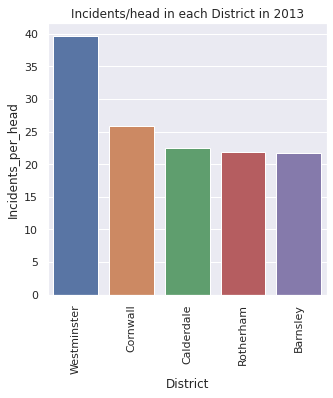

In [49]:
sns.set(rc = {'figure.figsize':(5,5)})
yr2013 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2013),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2013 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2013)
plt_2013.set_xticklabels(plt_2013.get_xticklabels(), rotation=90)
plt_2013.set(title='Incidents/head in each District in 2013')


[Text(0.5, 1.0, 'Incidents/head in each District in 2014')]

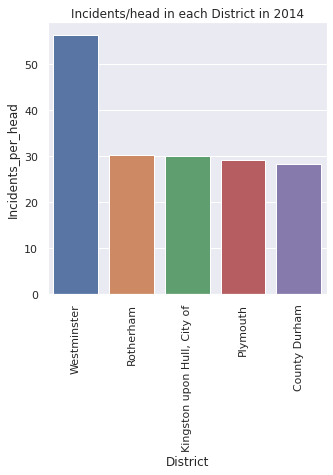

In [52]:
yr2014 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2014),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2014 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2014)
plt_2014.set_xticklabels(plt_2014.get_xticklabels(), rotation=90)
plt_2014.set(title='Incidents/head in each District in 2014')


[Text(0.5, 1.0, 'Incidents/head in each District in 2015')]

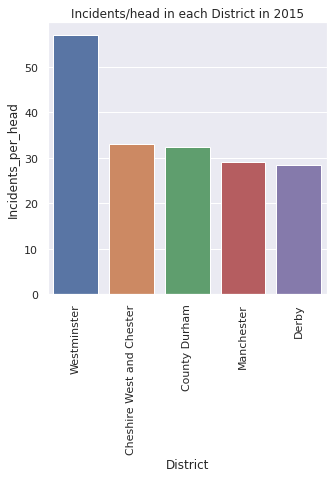

In [53]:
yr2015 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2015),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2015 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2015)
plt_2015.set_xticklabels(plt_2015.get_xticklabels(), rotation=90)
plt_2015.set(title='Incidents/head in each District in 2015')

[Text(0.5, 1.0, 'Incidents/head in each District in 2016')]

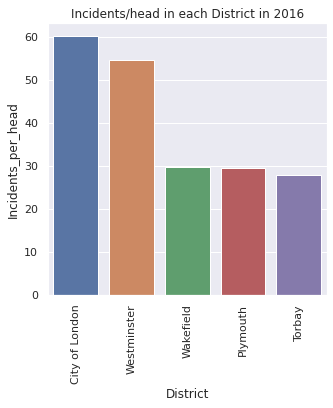

In [54]:
yr2016 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2016),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2016 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2016)
plt_2016.set_xticklabels(plt_2016.get_xticklabels(), rotation=90)
plt_2016.set(title='Incidents/head in each District in 2016')

[Text(0.5, 1.0, 'Incidents/head in each District in 2017')]

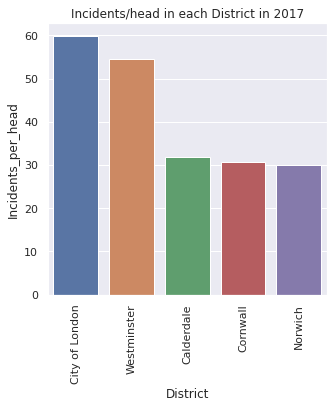

In [55]:
yr2017 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2017),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2017 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2017)
plt_2017.set_xticklabels(plt_2017.get_xticklabels(), rotation=90)
plt_2017.set(title='Incidents/head in each District in 2017')

[Text(0.5, 1.0, 'Incidents/head in each District in 2018')]

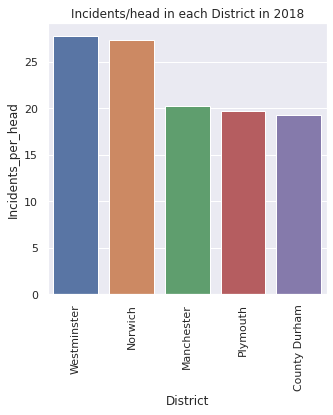

In [56]:
yr2018 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2018),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2018 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2018)
plt_2018.set_xticklabels(plt_2018.get_xticklabels(), rotation=90)
plt_2018.set(title='Incidents/head in each District in 2018')

[Text(0.5, 1.0, 'Incidents/head in each District in 2019')]

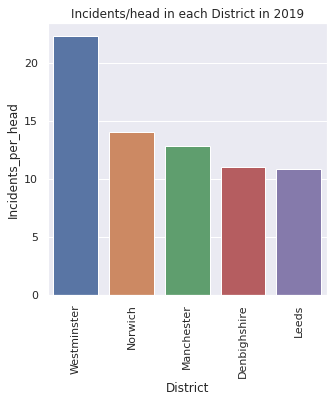

In [57]:
yr2019 = firearm_incidents_year_top_5PD.loc[(firearm_incidents_year_top_5PD['Year'] == 2019),\
                                                                                        ['District', 'Incidents_per_head']] 
plt_2019 = sns.barplot(x = 'District', y = 'Incidents_per_head', data = yr2019)
plt_2019.set_xticklabels(plt_2019.get_xticklabels(), rotation=90)
plt_2019.set(title='Incidents/head in each District in 2019')

## Observations:

From the charts above, Westminster/City of London ranked highly as Districts/Cities with highest incidence of firearm incidents per head between 2013 and 2019. Notably, Birmingham do not rank within the top 5 cities in any year.

Hence second claim is False.

# Claim 3: Crimes involving firearms are closely associated with drugs offences

## Data Extraction and Filtering
In this section, the relevant crime type (Firearm incidents) is extracted.

In [58]:
# display unique crimes in Crime type column
# use truncate = False to show full output
df.select("Crime type").distinct().show(truncate=False)

+----------------------------+
|Crime type                  |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
|Anti-social behaviour       |
+----------------------------+



In [59]:
# extract the Date column and rows relating to 'Drugs' and 'Possession of weapons' Crime type only. For 'Possession 
# of weapons' Crime type, select rows where the Last outcome category is 'Offender sent to prison'
drugs_guns = df.select(to_date(col("Month"),"yyyy-MM").alias("Date"),'Crime type', 'Last outcome category')\
.where((df['Crime type'] == 'Drugs') | (df['Crime type'] == 'Possession of weapons') & \
                                             (df['Last outcome category'] == 'Offender sent to prison'))
drugs_guns.show(5)

+----------+----------+---------------------+
|      Date|Crime type|Last outcome category|
+----------+----------+---------------------+
|2011-09-01|     Drugs|                 null|
|2011-09-01|     Drugs|                 null|
|2011-09-01|     Drugs|                 null|
|2011-09-01|     Drugs|                 null|
|2011-09-01|     Drugs|                 null|
+----------+----------+---------------------+
only showing top 5 rows



In [60]:
# confirm that only 'Drugs' and 'Possession of weapons' Crime types are selected
drugs_guns.select("Crime type").distinct().show(truncate=False)

+---------------------+
|Crime type           |
+---------------------+
|Drugs                |
|Possession of weapons|
+---------------------+



In [61]:
# confirm that the dataset shows all outcomes of the 'Drugs' crime type as it is not specified that any of these categories
# should be ignored
drugs_guns.select("Last outcome category").distinct().show(truncate=False)

+---------------------------------------------------+
|Last outcome category                              |
+---------------------------------------------------+
|Offender ordered to pay compensation               |
|Offender given suspended prison sentence           |
|Court result unavailable                           |
|Defendant sent to Crown Court                      |
|Offender given penalty notice                      |
|Suspect charged as part of another case            |
|null                                               |
|Local resolution                                   |
|Offender given a caution                           |
|Offender given conditional discharge               |
|Investigation complete; no suspect identified      |
|Offender given absolute discharge                  |
|Under investigation                                |
|Awaiting court outcome                             |
|Defendant found not guilty                         |
|Offender sent to prison    

In [62]:
# Confirm that only 'Possession of weapons' with 'Last outcome category' of 'Offender sent to prison' was selected since 
# this is the only situation that constitutes a 'Firearm incident'.
drugs_guns.where((drugs_guns['Crime type'] == 'Possession of weapons')).select('Last outcome category').distinct()\
                                                                                                .show(truncate=False)

+-----------------------+
|Last outcome category  |
+-----------------------+
|Offender sent to prison|
+-----------------------+



### Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models, markdown, code, markdown

### Objective
This section follows the following steps to visualize the relationship between firearm incidents and drug offences.

Step 1: Get monthly counts of both crimes and visualize their distributions.

Step 2: Visualize the monthly counts of both crime types using a scatterplot.

In [64]:
# get monthly count of the diffrent crime types: Drugs and Possession of weapons
count_by_month = drugs_guns.groupBy('Date').pivot('Crime type').count()

# replace nulls with zero and sort by Date
count_by_month = count_by_month.na.fill(value=0, subset = ['Possession of weapons']).sort('Date', ascending = True)
count_by_month.show(5)

+----------+-----+---------------------+
|      Date|Drugs|Possession of weapons|
+----------+-----+---------------------+
|2011-09-01|16551|                    0|
|2011-10-01|17932|                    0|
|2011-11-01|17731|                    0|
|2011-12-01|16816|                    0|
|2012-01-01|17663|                    0|
+----------+-----+---------------------+
only showing top 5 rows



array([[<AxesSubplot:xlabel='Drugs', ylabel='Drugs'>,
        <AxesSubplot:xlabel='Possession of weapons', ylabel='Drugs'>],
       [<AxesSubplot:xlabel='Drugs', ylabel='Possession of weapons'>,
        <AxesSubplot:xlabel='Possession of weapons', ylabel='Possession of weapons'>]],
      dtype=object)

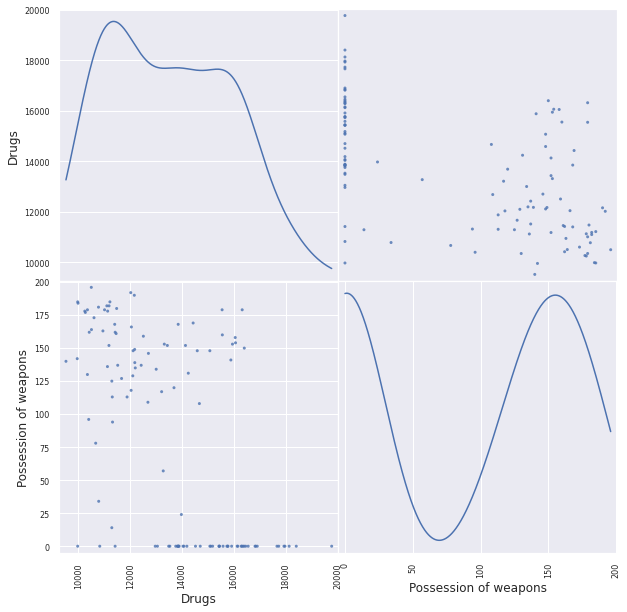

In [66]:
# visualize the distributions of the monthly count of Drugs and Possession of weapons 
monthly_drugs_guns = count_by_month.toPandas()
scatter_matrix(monthly_drugs_guns, alpha=0.8, figsize= (10,10), diagonal ='kde')


<AxesSubplot:xlabel='Possession of weapons', ylabel='Drugs'>

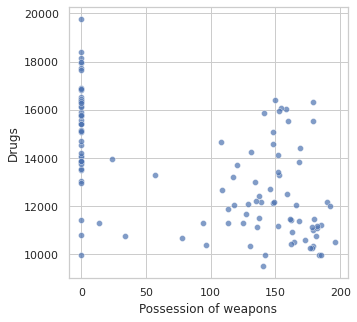

In [67]:
# visualize as a scatterplot
sns.set(style='whitegrid')
sns.scatterplot(y='Drugs', x='Possession of weapons', alpha=0.7, data=monthly_drugs_guns)

### Observation

From the grid chart showing the distributions of both crime types, it can be observed that they have very different distributions with monthly count of Drug offences peaking around 12,000 while the Possession of weapons has 2 peaks namely: when there are zero count and around 160 per month. 

On the scatterplot, the relationship between these crime types cannot be easily determined hence it would be beneficial to calculate their correlation coefficients.

## Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures 

### Objective 

In this section, the correlation coefficients are calculated using Pearson and Spearman methods. This is visualized using a heatmap. This will show the type of relationship between firearm crimes and drugs offences. 

From the previous section, there are many cases where there was no firearm incident.

In [68]:
# select all columns except the 'Date' column
monthly_drugs_guns = count_by_month.select('Drugs', 'Possession of weapons')

In [69]:
# vectorize the dataframe to be able to find the pearson correlation
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=monthly_drugs_guns.columns, outputCol=vector_col) # to vectorize
df_vector = assembler.transform(monthly_drugs_guns).select(vector_col) # to assemble vectors

In [70]:
# get Pearson (default) correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [71]:
# get the spearman correlations
smatrix = Correlation.corr(df_vector, vector_col, method='spearman')
scor_np = smatrix.collect()[0][smatrix.columns[0]].toArray()

In [72]:
columns = ['Drugs', 'Possession of weapons']
pcor = pd.DataFrame(cor_np, columns= columns, index = None)

columns = ['Drugs', 'Possession of weapons']
scor = pd.DataFrame(scor_np, columns= columns, index = None)

In [73]:
# present the results of both correlations
print(pcor)
print(scor)

      Drugs  Possession of weapons
0  1.000000              -0.577656
1 -0.577656               1.000000
      Drugs  Possession of weapons
0  1.000000              -0.568386
1 -0.568386               1.000000


<AxesSubplot:>

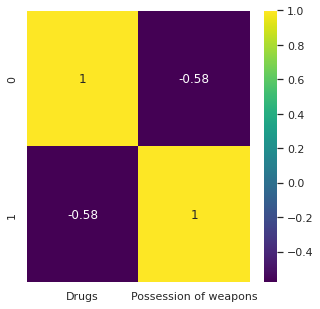

In [75]:
# visualize the pearson correlation (to 2 decimal point)
sns.heatmap(pcor, cmap = 'viridis', annot= True)

<AxesSubplot:>

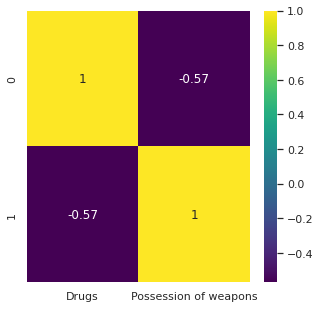

In [76]:
# visualize the spearman correlation (to 2 decimal point)
sns.heatmap(scor, cmap = 'viridis', annot= True)

In [78]:
# remove cases where Possession of weapons were zero
count_by_month2 = count_by_month.select('Drugs', 'Possession of weapons').where(count_by_month['Possession of weapons']>0)

# convert to pandas
monthly_drugs_guns = count_by_month2.toPandas()

# select all columns except the 'Date' column
monthly_drugs_guns = count_by_month2.select('Drugs', 'Possession of weapons')

# vectorize
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=monthly_drugs_guns.columns, outputCol=vector_col) # to vectorize
df_vector = assembler.transform(monthly_drugs_guns).select(vector_col) # to assemble vectors

In [79]:
# get Pearson (default) correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

# get the spearman correlations
smatrix = Correlation.corr(df_vector, vector_col, method='spearman')
scor_np = smatrix.collect()[0][smatrix.columns[0]].toArray()

columns = ['Drugs', 'Possession of weapons']
pcor = pd.DataFrame(cor_np, columns= columns, index = None)

columns = ['Drugs', 'Possession of weapons']
scor = pd.DataFrame(scor_np, columns= columns, index = None)

In [80]:
# present the results of both correlations
print(pcor)
print(scor)

      Drugs  Possession of weapons
0  1.000000              -0.045073
1 -0.045073               1.000000
      Drugs  Possession of weapons
0  1.000000              -0.192923
1 -0.192923               1.000000


<AxesSubplot:>

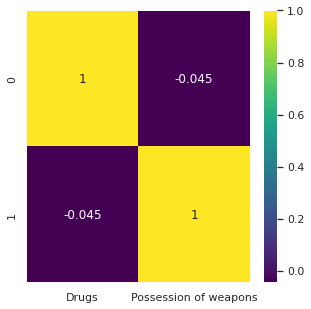

In [82]:
# visualize the pearson correlation (to 2 decimal point)
sns.heatmap(pcor, cmap = 'viridis', annot= True)


<AxesSubplot:>

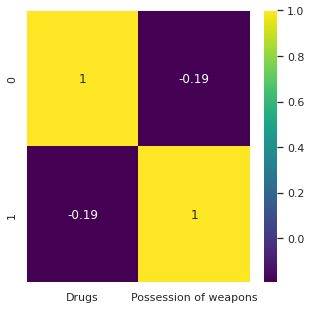

In [83]:
# visualize the spearman correlation (to 2 decimal point)
sns.heatmap(scor, cmap = 'viridis', annot= True)


### Observations:

From the plots results of the correlations (Spearman and Pearson) above, there is a moderate negative correlation between drug offences and firearm incidents. However, this relationship disappears if you discount instances where the count of firearm incident is zero.

Hence, the claim that firearm incidents are closely associated with drug offences cannot be determined as true. Furthermore, in Jay, et al. (2019)’s research into the effects of demolishing unoccupied buildings on firearm violence and drugs, they concluded that while over 5 demolitions resulted in a 11% reduction in firearm incidents, no effect was observed for drug offences.

# 6. Detailed Analysis and consideration of the appropriateness of the solution for the initial problem markdown

The solutions obtained addressed the initial problem which was to determine the validity of the three claims made by Ross Kemp in September 2018. The approach leaned heavily in pyspark and SQL which is appropriate since the domain of this report is in big data and cloud computing. 

The approach followed was to utilize just enough data to access each claim instead of extracting the data to access all claims at the beginning of the exercise. This approach was taken in consideration of the memory since the size of the dataset is big. 
To access the first and third claims, only all_crimes dataset was utilized as it was sufficient to obtain the counts of the relevant crimes whereas the postcode dataset was added to the all_crimes dataset in order to obtain the count of firearm incidents by different locations in the UK. 

The postcode dataset was utilized because it contained LSOA information which was more accurate than longitude and latitude in all_crimes dataset due to anonymization. The postcode dataset also had information about population which was needed to calculate the rate of crime per head.


# 7. Evaluation and Conclusion

This report analyzed crime data retrieved from the UK’s public crime website to understand the trend of violent crimes, firearm incidents, and drug offences in the UK between 2010 and 2021. Specifically, the analysis was focused on accessing Ross Kemp’s 2018 claims that violent crimes are increasing, the rate of firearm incidents per head are higher in Birmingham than any other place in the UK and there is a close association between firearm incidents and drug offences. 

The results showed that both monthly count and average annual count of violent crimes were  increasing year-on-year between 2014 and 2018 confirming the first claim. 

However, Westminster district dominated the top 5 rankings in rate of firearm incidents per head within the review period while Birmingham ranked between 17th and 43rd within 2013 and 2019 in contrast to the second claim. Perhaps the exclusion of all other outcomes except when the offender was sent to prison affected Birmingham’s position. 

Similarly, the report showed that while there is a moderate negative relationship between firearm incidents and drug offences, this is strongly influenced by including instances where there were no records of firearm incidents. When these are discarded, there are little to no association between these crimes. Hence, the validity of the third claim cannot be determined. 

# 8. References and Citation

[1] L. Tompson, S. Johnson, M. Ashby, C. Perkins, and P. Edwards, 'UK open source crime data: accuracy and possibilities for research', Cartography and Geographic Information Science, vol. 42, no. 2, pp. 97-111, Oct. 2014, doi: 10.1080/15230406.2014.972456

[2] The Crown Prosecution Service. “Violent Crime.” 
Available at: https://www.cps.gov.uk/crime-info/violent-crime (accessed 04 Dec. 2022).

[3] Federal Bureau of Investigations (FBI). “Crime in the United States.”
Available at: https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/violent-crime (accessed 04 Dec. 2020).

[4] Office of National Statistics. Gun deaths from 1980 to 2018, London, England: Office of National Statistics, 2018.

[5] Huffpost (2018) Is Birmingham Still The Gang And Gun Crime Capital Of The UK?. 
Available at: https://www.huffingtonpost.co.uk/entry/birmingham-gun-gang-crime_uk_5b3dfcd6e4b07b827cbdecc3 (accessed 04 Dec. 2022).
[6] J. Gunn, P. Boxer, T. Andrews, M. Ostermann, S. Bonne, M. Gusmano, E. Sloan-Power, and B. Hohl, “The Impact of Firearm Legislation on Firearm Deaths, 1991–2017,” Journal of Public Health, vol. 44, no.3, pp. 614–624, Aug. 2022, doi: 10.1093/pubmed/fdab047

[7] C. Hohl, S. Wiley, J. Wiebe, J. Culyba, R. Drake, and C. Branas, “Association of Drug and Alcohol Use With Adolescent Firearm Homicide at Individual, Family, and Neighborhood Levels,”  JAMA Internal Medicine, vol. 177, no. 3, pp. 317–324, Mar. 2017, doi: 10.1001/jamainternmed.2016.8180

[8] D. Lester and E. Murrell, “The preventive effect of strict gun control laws on suicide and homicide,” Suicide Life-Threat Behaviour, vol. 12, no. 3, pp. 131-140, Oct. 1982, doi: 10.1111/j.1943-278X.1982.tb00935.x

[9] J. Gunn, P. Boxer, T. Andrews, M. Ostermann, S. Bonne, M. Gusmano, E. Sloan-Power, and B. Hohl, “The Impact of Firearm Legislation on Firearm Deaths, 1991–2017,” Journal of Public Health, vol. 44, no.3, pp. 614–624, Aug. 2022, doi: 10.1093/pubmed/fdab047

[10] J. Donohue, V. Cai, V. Bondy, and J. Cook, “More Guns, More Unintended Consequences: The Effects of Right-to-Carry on Criminal Behaviour and Policing in US Cities,” National Bureau of Economic Research, Jan. 2022, doi: 10.2139/ssrn.4147260

[11] S. M. Ganpat, L. Garius, A. Tseloni, and N. Tilley, “Violence and the crime drop,” European Journal of Criminology, vol. 19, no. 4, pp. 767–790, May 2022, doi: 10.1177/1477370820913456 

[12] C. Lightowlers, J. Pina-Sánchez, and F. McLaughlin, “The role of deprivation and alcohol availability in shaping trends in violent crime,” European Journal of Criminology, Aug. 2021, doi: 10.1177/14773708211036081

[13] L. Liu, J. Chang, D. Long, and H. Liu, “Analyzing the Impact of COVID-19 Lockdowns on Violent Crime,” Journal of Environmental Research and Public Health, vol. 19, no. 23, Nov. 2022, doi: 10.3390/ijerph192315525

[14] J. Jay, L. W. Miratrix, C. Branas, M. A. Zimmerman, and D. Hemenway, “Urban building demolitions, firearm violence and drug crime,” Journal of Behavioral Medicine,  vol. 42, no.1, pp. 626–634, Aug. 2019, doi: 10.1007/s10865-019-00031-6